- https://www.alignmentforum.org/posts/qykrYY6rXXM7EEs8Q/understanding-sae-features-with-the-logit-lens
- https://colab.research.google.com/github/jbloomAus/SAELens/blob/main/tutorials/logits_lens_with_features.ipynb

In [1]:
from IPython.display import Image
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

In [35]:
import plotly_express as px

In [36]:
import numpy as np

In [25]:
from transformer_lens import HookedTransformer
from sae_lens import SAE
# Virtual Weight / Feature Statistics Functions
from sae_lens.analysis.feature_statistics import (
    get_all_stats_dfs,
    get_W_U_W_dec_stats_df,
    get_stats_df
)

In [42]:
from sae_lens.analysis.neuronpedia_integration import get_neuronpedia_quick_list

###  Loading GPT2 Small and SAE Weights

In [3]:
model = HookedTransformer.from_pretrained("gpt2-small")

/home/whaow/anaconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1602: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


In [4]:
# 'n_layers': 12,
# 'd_model': 768, 'd_head': 64, 'n_heads': 12,
model.cfg

HookedTransformerConfig:
{'NTK_by_parts_factor': 8.0,
 'NTK_by_parts_high_freq_factor': 4.0,
 'NTK_by_parts_low_freq_factor': 1.0,
 'act_fn': 'gelu_new',
 'attention_dir': 'causal',
 'attn_only': False,
 'attn_scale': 8.0,
 'attn_scores_soft_cap': -1.0,
 'attn_types': None,
 'checkpoint_index': None,
 'checkpoint_label_type': None,
 'checkpoint_value': None,
 'd_head': 64,
 'd_mlp': 3072,
 'd_model': 768,
 'd_vocab': 50257,
 'd_vocab_out': 50257,
 'decoder_start_token_id': None,
 'default_prepend_bos': True,
 'device': device(type='cuda'),
 'dtype': torch.float32,
 'eps': 1e-05,
 'experts_per_token': None,
 'final_rms': False,
 'from_checkpoint': False,
 'gated_mlp': False,
 'init_mode': 'gpt2',
 'init_weights': False,
 'initializer_range': 0.02886751345948129,
 'load_in_4bit': False,
 'model_name': 'gpt2',
 'n_ctx': 1024,
 'n_devices': 1,
 'n_heads': 12,
 'n_key_value_heads': None,
 'n_layers': 12,
 'n_params': 84934656,
 'normalization_type': 'LNPre',
 'num_experts': None,
 'original

In [5]:
gpt2_small_sparse_autoencoders = {}
gpt2_small_sae_sparsities = {}

for layer in range(12):
    sae, original_cfg_dict, sparsity = SAE.from_pretrained(
        release="gpt2-small-res-jb",
        sae_id="blocks.0.hook_resid_pre",
        device="cpu",
    )
    gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"] = sae
    gpt2_small_sae_sparsities[f"blocks.{layer}.hook_resid_pre"] = sparsity

/home/whaow/anaconda3/lib/python3.10/site-packages/sae_lens/sae.py:145: UserWarning: 
This SAE has non-empty model_from_pretrained_kwargs. 
For optimal performance, load the model like so:
model = HookedSAETransformer.from_pretrained_no_processing(..., **cfg.model_from_pretrained_kwargs)
  warnings.warn(


### Statistical Properties of Feature Logit Distributions

In [6]:
# In the post, I focus on layer 8
layer = 8

In [7]:
# get the corresponding SAE and feature sparsities.
sparse_autoencoder = gpt2_small_sparse_autoencoders[f"blocks.{layer}.hook_resid_pre"]
log_feature_sparsity = gpt2_small_sae_sparsities[f"blocks.{layer}.hook_resid_pre"]

In [46]:
sparse_autoencoder

SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

In [8]:
log_feature_sparsity.shape

torch.Size([24576])

In [9]:
24576 / model.cfg.d_model

32.0

In [10]:
sparse_autoencoder.W_enc.shape, sparse_autoencoder.W_dec.shape

(torch.Size([768, 24576]), torch.Size([24576, 768]))

In [11]:
W_dec = sparse_autoencoder.W_dec

In [12]:
model.W_U.shape

torch.Size([768, 50257])

In [13]:
get_W_U_W_dec_stats_df??

Signature:
get_W_U_W_dec_stats_df(
    W_dec: torch.Tensor,
    model: transformer_lens.HookedTransformer.HookedTransformer,
    cosine_sim: bool = False,
) -> tuple[pandas.core.frame.DataFrame, torch.Tensor]
Docstring: <no docstring>
Source:   
@torch.no_grad()
def get_W_U_W_dec_stats_df(
    W_dec: torch.Tensor, model: HookedTransformer, cosine_sim: bool = False
) -> tuple[pd.DataFrame, torch.Tensor]:
    W_U = model.W_U.detach().cpu()
    if cosine_sim:
        W_U = W_U / W_U.norm(dim=0, keepdim=True)
    dec_projection_onto_W_U = W_dec @ W_U
    W_U_stats_df = get_stats_df(dec_projection_onto_W_U)
    return W_U_stats_df, dec_projection_onto_W_U
File:      ~/anaconda3/lib/python3.10/site-packages/sae_lens/analysis/feature_statistics.py
Type:      function

In [14]:
W_dec.device

device(type='cpu')

In [15]:
W_dec.device

device(type='cpu')

In [16]:
model.W_U.device

device(type='cuda', index=0)

In [26]:
get_stats_df??

Signature: get_stats_df(projection: torch.Tensor)
Source:   
@torch.no_grad()
def get_stats_df(projection: torch.Tensor):
    """
    Returns a dataframe with the mean, std, skewness and kurtosis of the projection
    """
    mean = projection.mean(dim=1, keepdim=True)
    diffs = projection - mean
    var = (diffs**2).mean(dim=1, keepdim=True)
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0), dim=1)
    kurtosis = torch.mean(torch.pow(zscores, 4.0), dim=1)

    stats_df = pd.DataFrame(
        {
            "feature": range(len(skews)),
            "mean": mean.numpy().squeeze(),
            "std": std.numpy().squeeze(),
            "skewness": skews.numpy(),
            "kurtosis": kurtosis.numpy(),
        }
    )

    return stats_df
File:      ~/anaconda3/lib/python3.10/site-packages/sae_lens/analysis/feature_statistics.py
Type:      function

In [18]:
# calculate the statistics of the logit weight distributions
W_U_stats_df_dec, dec_projection_onto_W_U = get_W_U_W_dec_stats_df(
    W_dec, model, cosine_sim=False
)

In [29]:
# W_dec @ model.W_U.detach().cpu()
# 768 (from W_dec) project to 50257 (W_U)
dec_projection_onto_W_U.shape

torch.Size([24576, 50257])

In [33]:
W_U_stats_df_dec.shape

(24576, 5)

In [34]:
W_U_stats_df_dec.head()

feature          mean       std  skewness   kurtosis
0        0  7.590380e-11  0.189715  0.764198   9.097913
1        1 -9.260264e-09  0.166483  0.083962   3.300045
2        2 -4.554228e-10  0.203762  0.698958   6.764234
3        3  1.518076e-09  0.189168  0.627483   8.012762
4        4 -1.457353e-08  0.234610  1.676332  10.387129

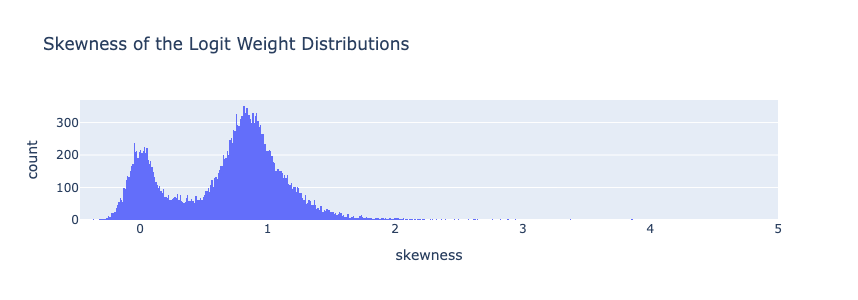

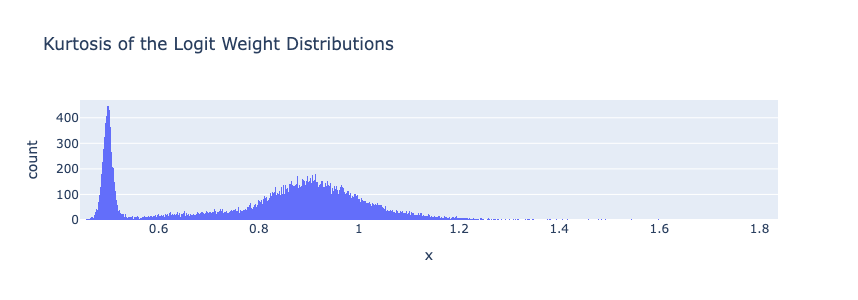

In [37]:
px.histogram(
    W_U_stats_df_dec,
    x="skewness",
    width=800,
    height=300,
    nbins=1000,
    title="Skewness of the Logit Weight Distributions",
).show()

px.histogram(
    W_U_stats_df_dec,
    x=np.log10(W_U_stats_df_dec["kurtosis"]),
    width=800,
    height=300,
    nbins=1000,
    title="Kurtosis of the Logit Weight Distributions",
).show()

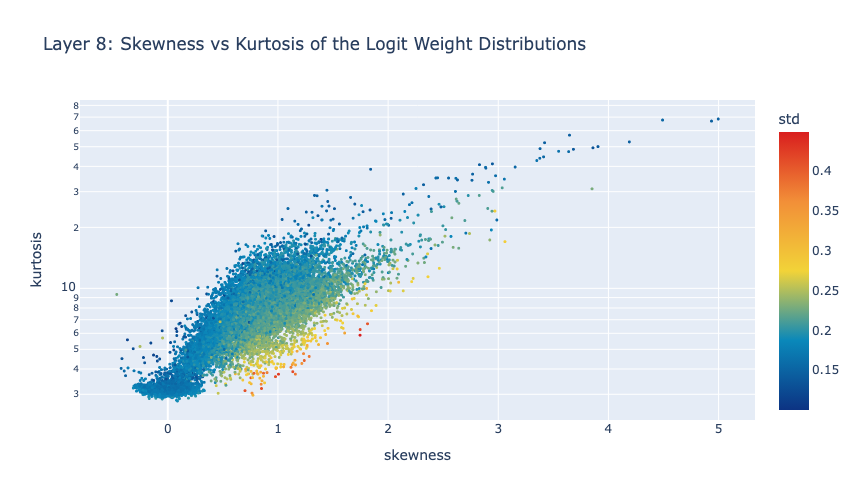

In [40]:
fig = px.scatter(
    W_U_stats_df_dec,
    x="skewness",
    y="kurtosis",
    color="std",
    color_continuous_scale="Portland",
    hover_name="feature",
    width=800,
    height=500,
    log_y=True,  # Kurtosis has larger outliers so logging creates a nicer scale.
    labels={"x": "Skewness", "y": "Kurtosis", "color": "Standard Deviation"},
    title=f"Layer {8}: Skewness vs Kurtosis of the Logit Weight Distributions",
)

# decrease point size
fig.update_traces(marker=dict(size=3))


fig.show()

In [43]:
# then you can query accross combinations of the statistics to find features of interest and open them in neuronpedia.
tmp_df = W_U_stats_df_dec[["feature", "skewness", "kurtosis", "std"]]
# tmp_df = tmp_df[(tmp_df["std"] > 0.04)]
# tmp_df = tmp_df[(tmp_df["skewness"] > 0.65)]
tmp_df = tmp_df[(tmp_df["skewness"] > 3)]
tmp_df = tmp_df.sort_values("skewness", ascending=False).head(10)
display(tmp_df)

# if desired, open the features in neuronpedia
get_neuronpedia_quick_list(sparse_autoencoder, list(tmp_df.feature))

feature  skewness   kurtosis       std
21461    21461  4.997022  68.520027  0.147476
2243      2243  4.935740  66.889091  0.145082
23720    23720  4.491526  67.694000  0.153658
419        419  4.189988  52.835106  0.145135
18710    18710  3.905093  50.059891  0.139519
14941    14941  3.859169  49.382679  0.134501
21407    21407  3.851373  30.988358  0.228910
10615    10615  3.682018  48.561260  0.138532
10442    10442  3.646617  57.019684  0.145679
18654    18654  3.638960  47.288048  0.157968

'https://neuronpedia.org/quick-list/?name=temporary_list&features=%5B%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2221461%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%222243%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2223720%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%22419%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2218710%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2214941%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2221407%22%7D%2C%20%7B%22modelId%22%3A%20%22gpt2-small%22%2C%20%22layer%22%3A%20%220-res-jb%22%2C%20%22index%22%3A%20%2210615%2

In [45]:
tmp_df.feature

21461    21461
2243      2243
23720    23720
419        419
18710    18710
14941    14941
21407    21407
10615    10615
10442    10442
18654    18654
Name: feature, dtype: int64

### Token Set Enrichment Analysis

In [55]:
import nltk

nltk.download("averaged_perceptron_tagger")

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/whaow/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [49]:
vocab = model.tokenizer.get_vocab() 

In [50]:
type(vocab)

dict

In [54]:
vocab['hello'], vocab['Ġhello']

(31373, 23748)